# Swaps de Libor

Se importa la versión de `QC_Financial` compilada para Python3.

In [12]:
from finrisk import QC_Financial_3 as Qcf

Para desplegar imágenes.

In [13]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "./assets/"

Para desplegar las tablas de desarrollo de las patas de un swap.

In [25]:
import pandas as pd
format_dict = {'nominal': '{0:,.2f}', 'amort': '{0:,.2f}', 'interes': '{0:,.2f}', 'flujo': '{0:,.2f}',
               'icp_inicial': '{0:,.2f}', 'icp_final': '{0:,.2f}',
               'valor_tasa': '{0:,.4%}', 'spread': '{0:,.4%}', 'gearing': '{0:,.2f}',
               'amort_moneda_pago': '{0:,.2f}', 'interes_moneda_pago': '{0:,.2f}', 'valor_indice_fx': '{0:,.2f}'}

## Libor

- Libor (London Interbank Offered Rate) es una tasa referencial interbancaria de Londres que se publica para 5 divisas y 7 plazos.
- Originalmente, esta tasa era publicada por la Asociación de Bancos Británicos (BBA), sin embargo, debido a episodios de manipulación, esta responsabilidad fue entregada a la división de administración de benchmarks de ICE (Intercontinental Exchange).
- Todos los detalles técnicos de su determinación y convenciones pueden consultarse en https://www.theice.com/iba/libor.

Veamos de todas maneras un ejemplo de la Libor USD 3M:

In [14]:
fecha_fixing = Qcf.QCDate(8, 8, 2014)
valor = .002351
print("La fecha fixing es {0:} y el valor es {1:.4%}".format(fecha_fixing, valor))

La fecha fixing es 8-8-2014 y el valor es 0.2351%


In [15]:
# Se define un calendario
london = Qcf.BusinessCalendar(fecha_fixing, 2)

In [16]:
# Se calcula la fecha valor
fecha_valor = london.shift(fecha_fixing, 2)
print("Fecha valor: {}".format(fecha_valor))

Fecha valor: 12-8-2014


In [17]:
# Se calcula la fecha final
fecha_final = london.next_busy_day(fecha_valor.add_months(3))
print("Fecha final: {}".format(fecha_final))

Fecha final: 12-11-2014


La Libor USD es una tasa Lineal ACT/360. Calculamos el factor de capitalización del ejemplo anterior:

In [18]:
# Fracción de año
act_360 = Qcf.QCAct360()

# Tipo de factor de capitalización
lin = Qcf.QCLinearWf()

In [19]:
# Objeto tasa de interés
libor_usd_3m = Qcf.QCInterestRate(valor, act_360, lin)

In [20]:
# Cálculo del factor de capitalización
print("Cálculo: {}".format(libor_usd_3m.wf(fecha_valor, fecha_final)))

Cálculo: 1.000600811111111


In [21]:
# Check
d = fecha_valor.day_diff(fecha_final)
print("Check: {}".format(1 + valor * d / 360))

Check: 1.000600811111111


### El Fin de la Libor

https://www.economist.com/finance-and-economics/2019/06/08/libor-is-due-to-die-in-2021-hurry-up-and-drop-it-say-regulators

### El Reemplazo más Probable

https://apps.newyorkfed.org/markets/autorates/sofr

## Swaps de Libor USD

### Funcionamiento del Mercado

- Existe un mercado profundo over-the-counter en las mayores divisas (por ejemplo EUR y USD)
- Aunque un cliente puede solicitar un swap con cualquier estructura, existen una serie de contratos estándar que son los que los traders de swaps cotizan y que, por lo tanto, cuentan con la mayor liquidez
- Para Libor USD, los swaps se cotizan a plazos anuales desde 1Y, 2Y (3Y, 4Y, 5Y,…) hasta 30Y y son de Libor 3M versus tasa fija pagadera semestralmente Lineal 30/360.
- Las nuevas regulaciones surgidas después de la crisis del 2008 (por ejemplo la ley Dodd-Frank en US) obligan a los bancos de un cierto tamaño e importancia a novar sus operaciones OTC a una cámara de compensación. Ver por ejemplo https://www.cmegroup.com/trading/otc/latin-american-swap-clearing.html.
- En estas cámaras de compensación el M2M de los swaps se calcula diariamente y debe constituirse como garantía. La garantía se remunera diariamente usando effective fed funds.
- Es probable que la remuneración cambie en el futuro y se comience a utilizar SOFR.

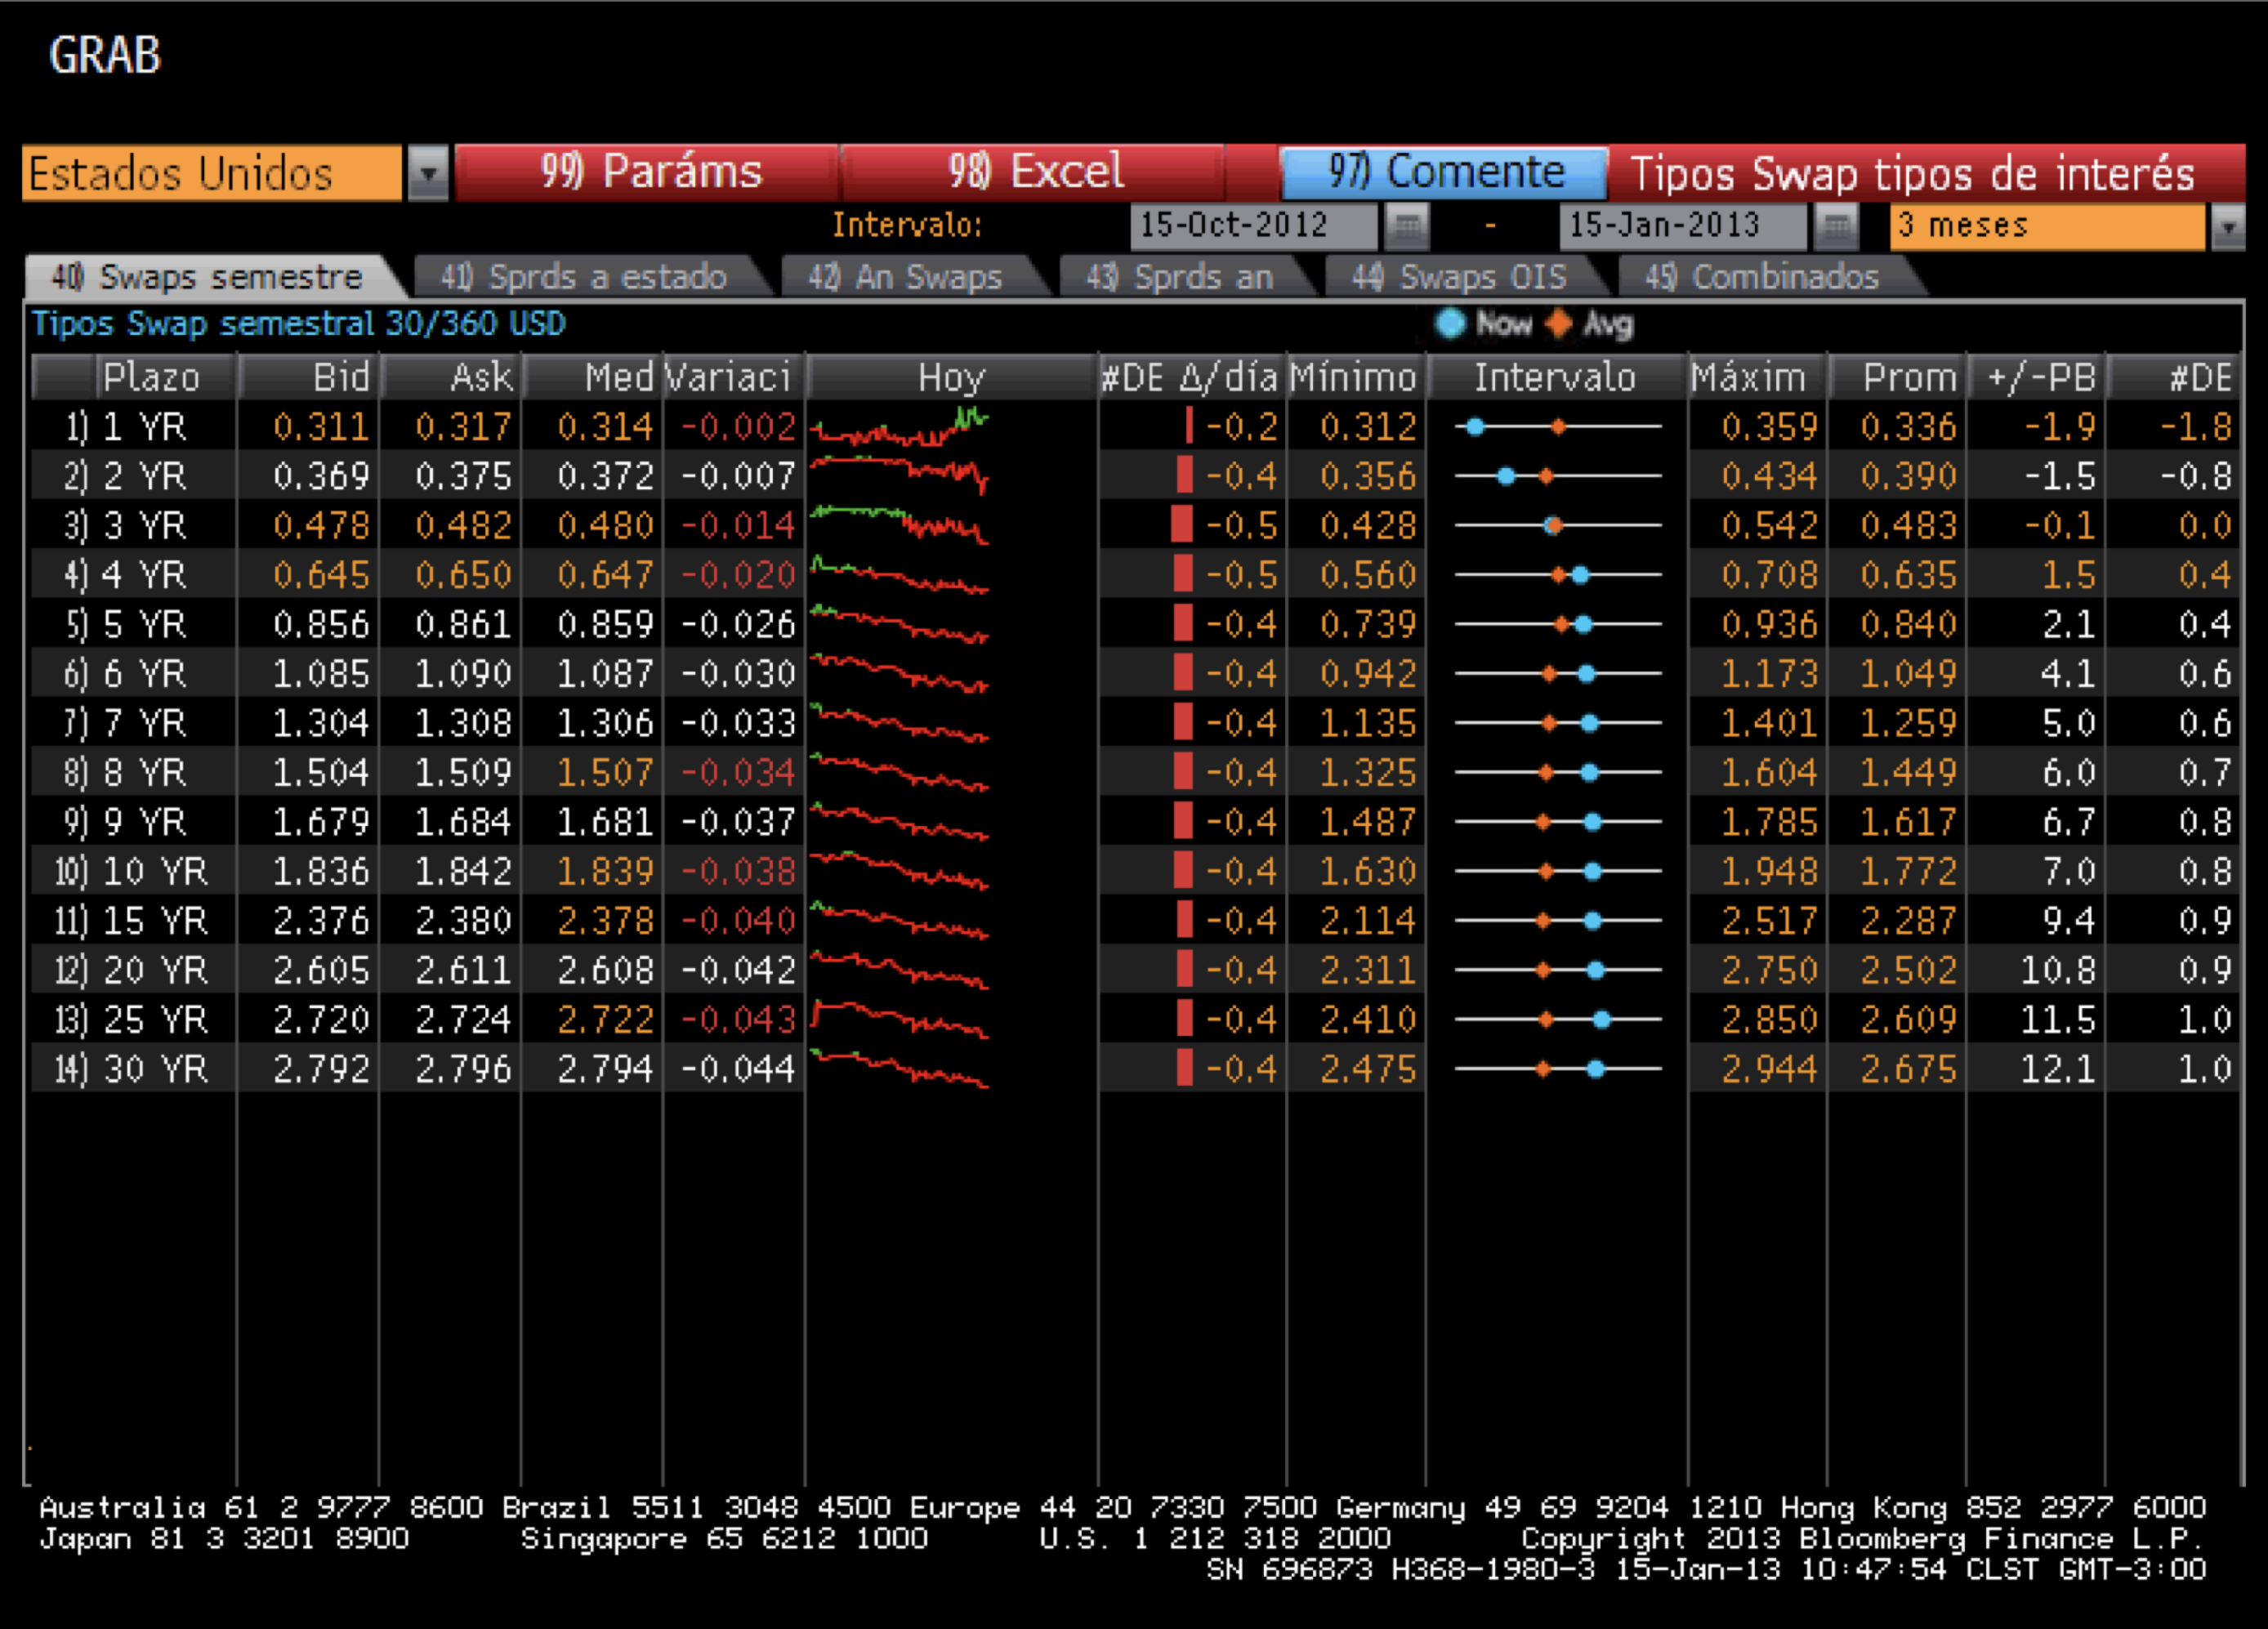

In [22]:
Image(filename = PATH + "swaps_libor_3m_bbg.png", width=1000, height=500)

### Ejemplo

Se construirá la pata fija y la pata flotante de un swap estándar Libor USD 3M versus tasa fija. 

#### Parámetros para Ambas Patas

In [41]:
fecha_quote = Qcf.QCDate(15, 1, 2013)
calendario = Qcf.BusinessCalendar(fecha_quote, 30)
fecha_inicio = calendario.shift(fecha_quote, 2)
plazo = Qcf.Tenor('5Y')
fecha_final = fecha_inicio.add_months(plazo.get_years() * 12)
usd = Qcf.QCUSD()
nominal = 100000.0
amort_es_flujo = False

#### Pata Fija

In [42]:
rp = Qcf.RecPay.RECEIVE
bus_adj_rule = Qcf.BusyAdjRules.MODFOLLOW
periodicidad = Qcf.Tenor('6M')
periodo_irregular = Qcf.StubPeriod.SHORTFRONT
lag_pago = 0
valor_tasa = 0.00859
tasa_cupon = Qcf.QCInterestRate(valor_tasa, t30360, lin)
es_bono = False

# Se da de alta el objeto
fixed_rate_leg = Qcf.LegFactory.build_bullet_fixed_rate_leg(rp,
                                                            fecha_inicio,
                                                            fecha_final,
                                                            bus_adj_rule,
                                                            periodicidad,
                                                            periodo_irregular,
                                                            calendario,
                                                            lag_pago,
                                                            nominal,
                                                            amort_es_flujo,
                                                            tasa_cupon,
                                                            usd,
                                                            es_bono)

In [36]:
# Se define un list donde almacenar los resultados de la función show
tabla = []
for i in range(0, fixed_rate_leg.size()):
    tabla.append(Qcf.show(fixed_rate_leg.get_cashflow_at(i)))

# Se utiliza tabla para inicializar el Dataframe
columnas = ['fecha_ini', 'fecha_fin', 'fecha_pago', 'nominal', 'amort', 'interes', 'amort_es_flujo', 'flujo', 'moneda',
            'valor_tasa', 'tipo_tasa']
df = pd.DataFrame(tabla, columns=columnas)

# Se despliega la data en este formato
df.style.format(format_dict)

,fecha_ini,fecha_fin,fecha_pago,nominal,amort,interes,amort_es_flujo,flujo,moneda,valor_tasa,tipo_tasa
0,2013-01-17,2013-07-17,2013-07-17,"100,000.00",0.00,429.50,False,429.50,USD,0.8590%,Lin30360
1,2013-07-17,2014-01-17,2014-01-17,"100,000.00",0.00,429.50,False,429.50,USD,0.8590%,Lin30360
2,2014-01-17,2014-07-17,2014-07-17,"100,000.00",0.00,429.50,False,429.50,USD,0.8590%,Lin30360
3,2014-07-17,2015-01-19,2015-01-19,"100,000.00",0.00,434.27,False,434.27,USD,0.8590%,Lin30360
4,2015-01-19,2015-07-17,2015-07-17,"100,000.00",0.00,424.73,False,424.73,USD,0.8590%,Lin30360
5,2015-07-17,2016-01-18,2016-01-18,"100,000.00",0.00,431.89,False,431.89,USD,0.8590%,Lin30360
6,2016-01-18,2016-07-18,2016-07-18,"100,000.00",0.00,429.50,False,429.50,USD,0.8590%,Lin30360
7,2016-07-18,2017-01-17,2017-01-17,"100,000.00",0.00,427.11,False,427.11,USD,0.8590%,Lin30360
8,2017-01-17,2017-07-17,2017-07-17,"100,000.00",0.00,429.50,False,429.50,USD,0.8590%,Lin30360
9,2017-07-17,2018-01-17,2018-01-17,"100,000.00","100,000.00",429.50,False,429.50,USD,0.8590%,Lin30360


#### Pata Flotante

In [45]:
# Se da de alta los parámetros requeridos
rp = Qcf.RecPay.PAY
bus_adj_rule = Qcf.BusyAdjRules.MODFOLLOW
periodicidad_pago = Qcf.Tenor('3M')
periodo_irregular_pago = Qcf.StubPeriod.NO
lag_pago = 0
periodicidad_fijacion = Qcf.Tenor('3M')
periodo_irregular_fijacion = Qcf.StubPeriod.NO

# Vamos a usar el mismo calendario para pago y fijaciones
lag_de_fijacion = 2

# Definición del índice
codigo = 'LIBORUSD3M'
valor_libor = .00303
lin_act360 = Qcf.QCInterestRate(valor_libor, act_360, lin)
fixing_lag = Qcf.Tenor('2d')
tenor = Qcf.Tenor('3m')
fixing_calendar = calendario
settlement_calendar = calendario
libor_usd_3m = Qcf.InterestRateIndex(codigo,
                                    lin_act360,
                                    fixing_lag,
                                    tenor,
                                    fixing_calendar,
                                    settlement_calendar,
                                    usd)
# Fin índice

spread = 0.0
gearing = 1.0

ibor_leg = Qcf.LegFactory.build_bullet_ibor_leg(rp, fecha_inicio, fecha_final, bus_adj_rule, periodicidad_pago,
                                                periodo_irregular_pago, calendario, lag_pago,
                                                periodicidad_fijacion, periodo_irregular_fijacion,
                                                calendario, lag_de_fijacion, libor_usd_3m,
                                                nominal, amort_es_flujo, usd, spread, gearing)

In [46]:
# Se define un list donde almacenar los resultados de la función show
tabla = []
for i in range(0, ibor_leg.size()):
    tabla.append(Qcf.show(ibor_leg.get_cashflow_at(i)))

# Se utiliza tabla para inicializar el Dataframe
columnas = ['fecha_inicial', 'fecha__final', 'fecha_fixing', 'fecha__pago', 'nominal', 'amort', 'interes', 'amort_es_flujo', 'flujo',
            'moneda', 'codigo_indice', 'valor_tasa', 'spread', 'gearing', 'tipo_tasa']
df1 = pd.DataFrame(tabla, columns=columnas)

# Se despliega la data en este formato
df1.style.format(format_dict)

,fecha_inicial,fecha__final,fecha_fixing,fecha__pago,nominal,amort,interes,amort_es_flujo,flujo,moneda,codigo_indice,valor_tasa,spread,gearing,tipo_tasa
0,2013-01-17,2013-04-17,2013-01-15,2013-04-17,"-100,000.00",0.00,-75.75,False,-75.75,USD,LIBORUSD3M,0.3030%,0.0000%,1.00,LinAct360
1,2013-04-17,2013-07-17,2013-04-15,2013-07-17,"-100,000.00",0.00,-76.59,False,-76.59,USD,LIBORUSD3M,0.3030%,0.0000%,1.00,LinAct360
2,2013-07-17,2013-10-17,2013-07-15,2013-10-17,"-100,000.00",0.00,-77.43,False,-77.43,USD,LIBORUSD3M,0.3030%,0.0000%,1.00,LinAct360
3,2013-10-17,2014-01-17,2013-10-15,2014-01-17,"-100,000.00",0.00,-77.43,False,-77.43,USD,LIBORUSD3M,0.3030%,0.0000%,1.00,LinAct360
4,2014-01-17,2014-04-17,2014-01-15,2014-04-17,"-100,000.00",0.00,-75.75,False,-75.75,USD,LIBORUSD3M,0.3030%,0.0000%,1.00,LinAct360
5,2014-04-17,2014-07-17,2014-04-15,2014-07-17,"-100,000.00",0.00,-76.59,False,-76.59,USD,LIBORUSD3M,0.3030%,0.0000%,1.00,LinAct360
6,2014-07-17,2014-10-17,2014-07-15,2014-10-17,"-100,000.00",0.00,-77.43,False,-77.43,USD,LIBORUSD3M,0.3030%,0.0000%,1.00,LinAct360
7,2014-10-17,2015-01-19,2014-10-15,2015-01-19,"-100,000.00",0.00,-79.12,False,-79.12,USD,LIBORUSD3M,0.3030%,0.0000%,1.00,LinAct360
8,2015-01-19,2015-04-17,2015-01-15,2015-04-17,"-100,000.00",0.00,-74.07,False,-74.07,USD,LIBORUSD3M,0.3030%,0.0000%,1.00,LinAct360
9,2015-04-17,2015-07-17,2015-04-15,2015-07-17,"-100,000.00",0.00,-76.59,False,-76.59,USD,LIBORUSD3M,0.3030%,0.0000%,1.00,LinAct360
